# Large Deformation Problem: Mesh Refinement Study

## Problem Definition  

Consider a 2D cantilever beam beam with a uniformly distributed load on the bottom edge. The applied load is large, meaning that large deformations are expected, and the analytic solution will not apply.

<img src="cantileverBeam.png" align="center">

$L = 30 m$  
$H = 2m$  
$ q = 50 N/m^2$  
$ E = 100000$  
$ nu = 0.3$  
$ mu = \frac{E}{2(1+nu)}$  
$ kappa = \frac{E}{3(1-2nu)}$

## h-refinement

H-refinement refers to increasing the number of elements in the domain. The emelent size gets smaller to increase the mesh resolution. The h-refinment study will tak eplace in two parts: refining in the x-direction and in the y-direction. 

Material properties: mu=38461.538, kappa=83333.333

****** SOLVER ITERATIONS ******
Step 0, load factor = 0.200
Iteration 1, Correction=1.000000e+00, Residual=9.216307e-01, tolerance=1.000000e-10
Iteration 2, Correction=1.348360e-01, Residual=2.936221e+03, tolerance=1.000000e-10
Iteration 3, Correction=1.013219e-02, Residual=1.509889e+02, tolerance=1.000000e-10
Iteration 4, Correction=1.580653e-02, Residual=5.535426e-01, tolerance=1.000000e-10
Iteration 5, Correction=4.374220e-04, Residual=7.164272e-01, tolerance=1.000000e-10
Iteration 6, Correction=1.800793e-05, Residual=6.878708e-04, tolerance=1.000000e-10
Iteration 7, Correction=7.276420e-10, Residual=1.143235e-06, tolerance=1.000000e-10
Iteration 8, Correction=7.734888e-16, Residual=1.463349e-11, tolerance=1.000000e-10
Step 1, load factor = 0.400
Iteration 1, Correction=4.802157e-01, Residual=9.216307e-01, tolerance=1.000000e-10
Iteration 2, Correction=5.651580e-02, Residual=2.181163e+03, tolerance=1.000000e-10
Iteration 3, Correct

/scratch/334662.1.ood/ipykernel_1983375/3577411289.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


'/projectnb/me700/students/mlanduyt/finite-element-analysis/tutorials/deformation_tutorial.gif'

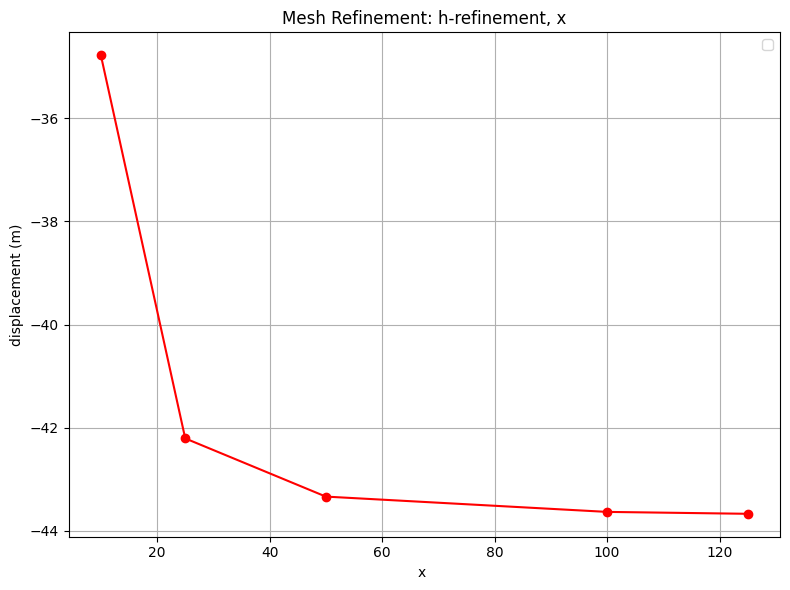

In [2]:
# h-refinement: x-direction

import warnings
warnings.simplefilter("always")
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os


# --- Beam and Mesh Info --- #

ele_type = "D2_nn4_quad"
ndof = 2   # 2 DOF per node (x, y)

L = 50.0      # length in x-direction
H = 2.0       # height in y-direction
nx_list = np.array([10, 25, 50, 100,125])  # number of elements in x
ny = 2

q = -20 # load per unit length 


# --- Material Properties --- #

E = 100000.0
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))

material_props = np.array([mu, kappa])
print(f"Material properties: mu={mu:.3f}, kappa={kappa:.3f}")


# --- Solution Info --- #

nr_num_steps = 5
all_tip_disp_x = []


# --- Mesh Study Loop --- #

for ix, nx in enumerate(nx_list):
    
    # --- Mesh Generation and BC --- #

    # Generate mesh
    coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)

    # Identify boundaries
    boundary_nodes, boundary_edges = pre.identify_rect_boundaries(coords, connect, ele_type, 0, L, 0, H)

    # Apply boundary conditions:

    # 1. Fix left boundary: both u_x and u_y = 0.
    fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)

    #2. Uniform downward traction on the top edge (y = H)
    dload_info = dload_info = pre.assign_uniform_load_rect(boundary_edges, "bottom", 0.0, q)

    # Combine fixed BCs (only one in this case)
    fixed_nodes = fixed_left


    # --- Run the Solver --- #

    print("\n****** SOLVER ITERATIONS ******")

    displacements_all, nr_info_all = hyperelastic_solver(
        material_props,
        ele_type,
        coords.T,      # solver expects coords as (ncoord, n_nodes)
        connect.T,     # and connectivity as (n_nodes_per_elem, n_elems)
        fixed_nodes,
        dload_info,
        nr_print=True,
        nr_num_steps=nr_num_steps,
        nr_tol=1e-10,
        nr_maxit=30,
    )

    final_disp = displacements_all[-1]  # final global displacement vector (length = n_nodes * ndof)

    # find a node close to the beam tip (x=L, y=H/2)
    tip_node = None
    tol = 1e-3
    for i, (x, y) in enumerate(coords):
        if abs(x - L) < tol and abs(y - H/2) < H/(2*ny):
            tip_node = i
            break
    if tip_node is None:
        raise ValueError("Could not find tip node near x=L, y=H/2.")

    # and find the displacement at this node
    tip_disp_y = final_disp[ndof*tip_node + 1]  # the y-component of displacement
    all_tip_disp_x.append(tip_disp_y)

# --- Plot Results --- #

%matplotlib inline
plt.figure(figsize=(8, 6))
plt.plot(nx_list, all_tip_disp_x, 'ro-')
plt.xlabel("x ")
plt.ylabel("displacement (m)")
plt.title("Mesh Refinement: h-refinement, x")
plt.legend()
plt.grid(True)
plt.tight_layout()

tutorials_dir = os.getcwd()

# --- Plot the mesh with the final deformed shape --- #

img_name = "mesh_refinement.gif"
fname = os.path.join(tutorials_dir, img_name)
viz.make_deformation_gif(displacements_all, coords, connect, ele_type, fname)
display(fname)



Material properties: mu=38461.538, kappa=83333.333

****** SOLVER ITERATIONS ******
Step 0, load factor = 0.200
Iteration 1, Correction=1.000000e+00, Residual=2.752092e-01, tolerance=1.000000e-10
Iteration 2, Correction=3.229851e-01, Residual=1.151901e+04, tolerance=1.000000e-10
Iteration 3, Correction=1.177076e-01, Residual=2.592652e+03, tolerance=1.000000e-10
Iteration 4, Correction=2.878983e-02, Residual=3.166139e+02, tolerance=1.000000e-10
Iteration 5, Correction=3.040484e-02, Residual=8.311700e+00, tolerance=1.000000e-10
Iteration 6, Correction=1.609902e-02, Residual=4.860545e+00, tolerance=1.000000e-10
Iteration 7, Correction=8.778187e-03, Residual=1.362750e+00, tolerance=1.000000e-10
Iteration 8, Correction=3.238931e-03, Residual=3.033530e-01, tolerance=1.000000e-10
Iteration 9, Correction=3.475418e-04, Residual=7.133521e-02, tolerance=1.000000e-10
Iteration 10, Correction=1.034955e-05, Residual=7.726383e-04, tolerance=1.000000e-10
Iteration 11, Correction=3.657325e-09, Residual

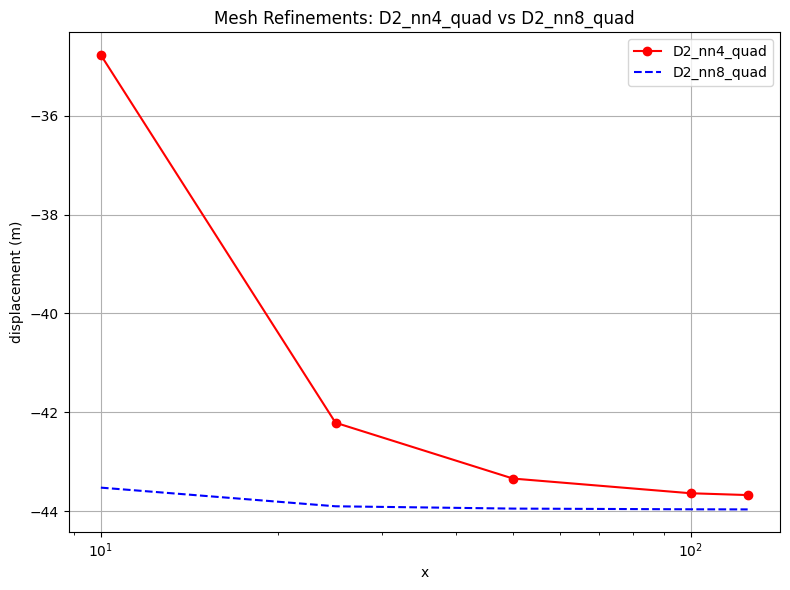

In [4]:
# p refinment code

# --- Beam and Mesh Info --- #

ele_type = "D2_nn8_quad"
ndof = 2        # 2 DOF per node (x, y)

L = 50.0      # length in x-direction
H = 2.0       # height in y-direction
nx_list_8 = np.array([10, 25, 50, 100,125])  # number of elements in x
ny = 2

q = -20 # load per unit length 

# --- Material Properties --- #

E = 100000.0
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))

material_props = np.array([mu, kappa])
print(f"Material properties: mu={mu:.3f}, kappa={kappa:.3f}")


# --- Solution Info --- #

nr_num_steps = 5
all_tip_disp_d8 = []


# --- Mesh Study Loop --- #

for ix, nx in enumerate(nx_list_8):
    
    # --- Mesh Generation and BC --- #

    # Generate mesh
    coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)

    # Identify boundaries
    boundary_nodes, boundary_edges = pre.identify_rect_boundaries(coords, connect, ele_type, 0, L, 0, H)

    # Apply boundary conditions:

    # 1. Fix left boundary: both u_x and u_y = 0.
    fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)

    #2. Uniform downward traction on the top edge (y = H)
    dload_info = dload_info = pre.assign_uniform_load_rect(boundary_edges, "bottom", 0.0, q)

    # Combine fixed BCs (only one in this case)
    fixed_nodes = fixed_left


    # --- Run the Solver --- #

    print("\n****** SOLVER ITERATIONS ******")

    displacements_all, nr_info_all = hyperelastic_solver(
        material_props,
        ele_type,
        coords.T,      # solver expects coords as (ncoord, n_nodes)
        connect.T,     # and connectivity as (n_nodes_per_elem, n_elems)
        fixed_nodes,
        dload_info,
        nr_print=True,
        nr_num_steps=nr_num_steps,
        nr_tol=1e-10,
        nr_maxit=30,
    )

    final_disp = displacements_all[-1]  # final global displacement vector (length = n_nodes * ndof)

    # find a node close to the beam tip (x=L, y=H/2)
    tip_node = None
    tol = 1e-3
    for i, (x, y) in enumerate(coords):
        if abs(x - L) < tol and abs(y - H/2) < H/(2*ny):
            tip_node = i
            break
    if tip_node is None:
        raise ValueError("Could not find tip node near x=L, y=H/2.")

    # and find the displacement at this node
    tip_disp_y = final_disp[ndof*tip_node + 1]  # the y-component of displacement

    all_tip_disp_d8.append(tip_disp_y)

%matplotlib inline
plt.figure(figsize=(8, 6))
plt.semilogx(nx_list, all_tip_disp_x, 'ro-', label="D2_nn4_quad")
plt.semilogx(nx_list_8, all_tip_disp_d8, 'b--', label="D2_nn8_quad")
plt.xlabel("x")
plt.ylabel("displacement (m)")
plt.title("Mesh Refinements: D2_nn4_quad vs D2_nn8_quad")
plt.legend()
plt.grid(True)
plt.tight_layout()